# SIT307 - Machine Learning Challenge (Assignment 3)

Our chosen dataset is [Life Expectancy (WHO)](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who).

Prepared by

| Student           | Student ID |
|-------------------|------------|
| HOOMAN SHYKHIPOUR | 220060109  |
| SARAH GOSLING     | 220094149  |
| DEVIN JAYASINGHE  | 220228075  |
| RYAN WAITES       | 215127684  |
| ANTHONY GEORGE    | 220180567  |
| MATT KINNIA       | 219311697  |

In [1]:
'''
Import all necessary libraries
'''

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Import the required packages for our regression models.
from statistics import mean
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import lars_path

In [2]:
# Ignore inline warnings thrown by packages
warnings.filterwarnings("ignore")

In [3]:
'''
Get our cleaned dataset
'''

life_df = pd.read_csv('Cleaned_Life_Expectancy_Data.csv', delimiter=',')

# Section 1: Introduction

### Aims
#### Building upon our previous analysis of the Life Expectancy dataset in Assignment 2, we identified key observable relationships between features, particularly regarding different features and their effects on Life Expectancy.

#### In this notebook we aim to confirm the best set of features and accurately predict life expectancy based upon these. To do so, we utilised three separate machine learning regression models, in the pursuit of creating the most accurate model for our problem, as follows...
-	#### Linear Regression
-	#### Artificial Neural Network Multi-Layer Perceptron Regression
-	#### LASSO Regression

### Hypothesis

#### We hypothesise that our best model will predict life expectancy within 2% accuracy, based on a testing and training ratio of 80 and 20 respectively.


# Section 2: Machine Learning

## Section 2.1: Regression

In [4]:
'''
Let's organise our features to use in our regression model
'''

# Convert country, a categorical text field, to a numerical class should we wish to use it in any models.
label_encoder = LabelEncoder()
life_df["COUNTRY_CLASS"] = label_encoder.fit_transform(life_df["COUNTRY"])

# Pull the required columns from the source dataset.
reg_life_df = life_df[["STATUS", "LIFE_EXPECTANCY", "ALCOHOL", "ADULT_MORTALITY","MEASLES","POLIO","DIPHTHERIA", "BMI", "INFANT_DEATHS","THINNESS_5-9_YEARS","THINNESS_10-19_YEARS", "SCHOOLING","INCOME_COMPOSITION_OF_RESOURCES"]]
reg_life_df = reg_life_df.dropna()

# Define our x (independent) and y (dependent) variables for our regression models.
x = reg_life_df[["STATUS", "ALCOHOL", "ADULT_MORTALITY", "BMI", "INFANT_DEATHS","MEASLES","POLIO","DIPHTHERIA","THINNESS_5-9_YEARS","THINNESS_10-19_YEARS", "SCHOOLING","INCOME_COMPOSITION_OF_RESOURCES"]]
y = reg_life_df["LIFE_EXPECTANCY"]

In [5]:
'''
Split data into testing and training data
'''

# Split our dataset into training and testing samples. We are using 80% for training and 20% for testing.
# NOTE: Using a the "random_state" parameter ensures we get repeatable results for each execution.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale our train and test features using standardization.
std_scaler = StandardScaler()
std_scaler.fit(x_train.values)

x_train_scaled = std_scaler.transform(x_train.values)
x_test_scaled  = std_scaler.transform(x_test.values)

### Linear Regression

Using an ordinary least squares Linear Regression model we can predict `LIFE_EXPECTANCY` using a one or more explanatory features.

In [6]:
'''
Build and train Linear Regression model
'''

# Create and train the ordinary least squares Linear Regression model based on our training data.
linear_regression = LinearRegression()
linear_regression.fit(x_train_scaled, y_train)

LinearRegression()

In [7]:
'''
Test model
'''

# Run a prediction using our testing data.
y_pred = linear_regression.predict(x_test_scaled)

#### Performance

In [8]:
'''
Evaluate Performance
'''

# Print the model's performance indicators.
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")  
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")  
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))}")

Coefficient of determination: 0.9238680302251875
Mean Absolute Error: 1.8176607104482667
Mean Squared Error: 6.53086525927772
Root Mean Squared Error: 2.5555557632886274


In [9]:
'''
Prediction comparison
'''

# Print actual vs predicted values. 
pd.DataFrame({"Actual": y_test, "Predicted": y_pred}).head(10)

,Actual,Predicted
783,70.2,68.608839
1615,69.6,68.791612
410,53.3,54.768536
1852,79.1,79.510794
523,45.7,44.771927
881,64.2,60.560052
883,63.3,59.547605
1444,73.6,74.201069
511,79.1,78.469725
1554,64.7,62.346559


[Text(0.5, 1.0, 'Actual vs. Predicted Life Expectancy'),
 Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value')]

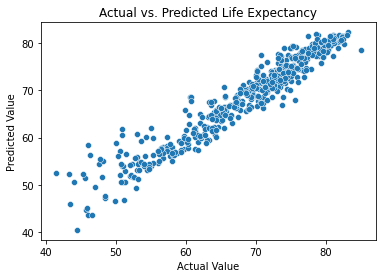

In [10]:
'''
Plot prediction comparison
'''

# Plot actual vs predicted values.
plot = sns.scatterplot(x=y_test, y=y_pred)
plot.set(title="Actual vs. Predicted Life Expectancy", xlabel="Actual Value", ylabel="Predicted Value")

#### Prediction

Predict life expectancy using previously unseen data.

In [11]:
'''
Perform prediction with new data
'''

# Provide a set of previously unseen features.
# STATUS, ALCOHOL, ADULT_MORTALITY, BMI, INFANT_DEATHS, MEASLES, POLIO, DIPHTHERIA, THINNESS_5-9_YEARS, THINNESS_10-19_YEARS, SCHOOLING, INCOME_COMPOSITION_OF_RESOURCES
new_features = [[0, 5, 300, 19, 82, 1495, 68, 40, 18, 17, 14, 0.5]]

# Scale these features using standardization 
new_features_scaled = std_scaler.transform(new_features)

# Predict the life expectancy given the new features
new_pred = linear_regression.predict(new_features_scaled)
print(f"Given provided features, the predicted life expectancy is: {new_pred[0]}")

Given provided features, the predicted life expectancy is: 55.88050060426035


### Lasso Regression 

####  finding best ALPHA value for L1 regularization,implementing lassoCV

In [12]:
'''
Determine best alpha, build and train LASSO regression model
'''

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(x_train_scaled, y_train)
# This is the best alpha value found
lasso_model.alpha_ 


0.012173827277396614

In [13]:
'''
View coeffecients
'''

# showing all coefficients with optimal alpha
list(zip(x_train.columns, lasso_model.coef_))

[('STATUS', 0.12540144182981472),
 ('ALCOHOL', -0.01712369191563207),
 ('ADULT_MORTALITY', -4.479060598744766),
 ('BMI', 0.18181222245651846),
 ('INFANT_DEATHS', 0.15874142618205433),
 ('MEASLES', -0.2850918092368945),
 ('POLIO', -0.0),
 ('DIPHTHERIA', 1.0785488519160236),
 ('THINNESS_5-9_YEARS', -0.036196874877915654),
 ('THINNESS_10-19_YEARS', -0.11107439652977479),
 ('SCHOOLING', 0.0),
 ('INCOME_COMPOSITION_OF_RESOURCES', 3.9669492280262597)]

In [14]:
'''
Test model
'''

# Run a prediction using our testing data.
y_pred_LASSO = lasso_model.predict(x_test_scaled)

#### Performance

In [15]:
'''
Evaluate Performance
'''

# Print the model's performance indicators.
print(f"Coefficient of determination: {r2_score(y_test, y_pred_LASSO)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_LASSO)}")  
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_LASSO)}")  
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred_LASSO))}")

Coefficient of determination: 0.9240796076950467
Mean Absolute Error: 1.816059783150613
Mean Squared Error: 6.512715407754936
Root Mean Squared Error: 2.552002235060725


In [16]:
'''
Prediction comparison
'''

# Print actual vs predicted values. 
pd.DataFrame({"Actual": y_test, "Predicted": y_pred_LASSO}).head(10)

,Actual,Predicted
783,70.2,68.455940
1615,69.6,68.862125
410,53.3,55.087929
1852,79.1,79.374050
523,45.7,44.632764
881,64.2,60.448725
883,63.3,59.496388
1444,73.6,74.190169
511,79.1,78.431741
1554,64.7,62.300865


[Text(0.5, 1.0, 'Actual vs. Predicted Life Expectancy'),
 Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value')]

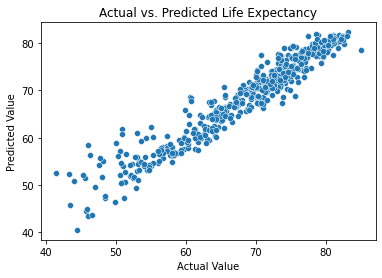

In [17]:
'''
Plot prediction comparison
'''

# Plot actual vs predicted values.
plot = sns.scatterplot(x=y_test, y=y_pred_LASSO)
plot.set(title="Actual vs. Predicted Life Expectancy", xlabel="Actual Value", ylabel="Predicted Value")

#### Prediction

In [18]:
'''
Test model with new data
'''

# Provide a set of previously unseen features.
# STATUS, ALCOHOL, ADULT_MORTALITY, BMI, INFANT_DEATHS, MEASLES, POLIO, DIPHTHERIA, THINNESS_5-9_YEARS, THINNESS_10-19_YEARS, SCHOOLING, INCOME_COMPOSITION_OF_RESOURCES
new_features = [[0, 5, 300, 19, 82, 1495, 68, 40, 18, 17, 14, 0.5]]

# Scale these features using standardization 
new_features_scaled = std_scaler.transform(new_features)

# Predict the life expectancy given the new features
new_pred = lasso_model.predict(new_features_scaled)
print(f"Given provided features, the predicted life expectancy is: {new_pred[0]}")

Given provided features, the predicted life expectancy is: 56.5586012759333


In [19]:
'''
Determine LARS path
'''

# Regularization path computation using the LARS
alphas, _, coefs = lars_path(x_train_scaled, y_train.values, method='lasso')

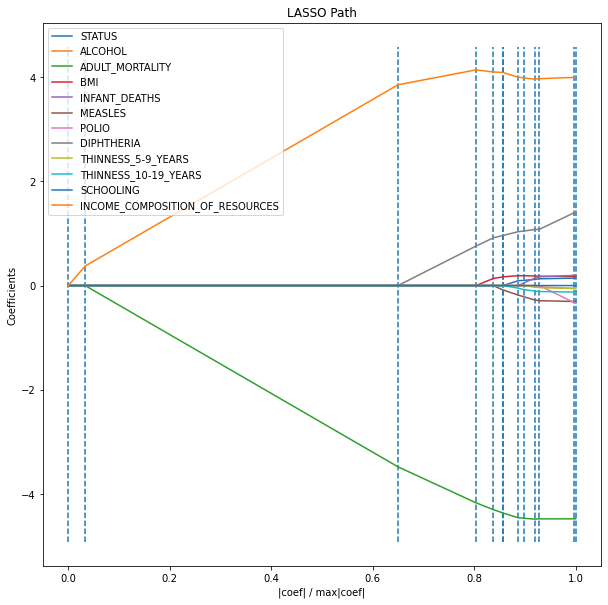

In [20]:
'''
Plot LARS path
'''

# plotting the LARS path
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(x_train.columns)
plt.show()

### Artificial Neural Network

In [21]:
'''
Split data into testing and training data, build and test model
'''

# split dataset into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# standardise the features individually before applying ML
sc=StandardScaler()

# fit standardised features
scaler = sc.fit(x_train)

# transform train and test data
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

#mlp = MLPRegressor(random_state=1, max_iter=10000).fit(x_train, y_train)
mlp = MLPRegressor(hidden_layer_sizes=(150),
                   max_iter = 10000, 
                   activation = 'relu',
                   solver = 'adam').fit(x_train_scaled, y_train)

# get prediction from test data 
predict_test = mlp.predict(x_test_scaled)

In [22]:
'''
Evaluate performance
'''

# print coefficients and errors
print(f"Coefficient of determination: {r2_score(y_test, predict_test)}")
print('Mean Absolute Error:', mean_absolute_error(y_test, predict_test))  
print('Mean Squared Error:', mean_squared_error(y_test, predict_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predict_test)))

Coefficient of determination: 0.957726822337482
Mean Absolute Error: 1.2661025766797236
Mean Squared Error: 3.626340264307098
Root Mean Squared Error: 1.9042952145891399


[Text(0.5, 1.0, 'Actual vs. Predicted Life Expectancy'),
 Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value')]

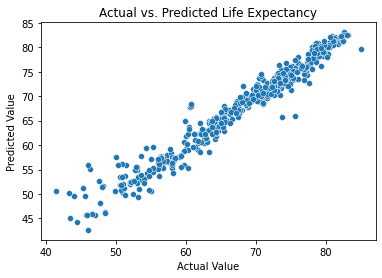

In [23]:
'''
Plot prediction comparison
'''

# Plot actual vs predicted values.
plot = sns.scatterplot(x=y_test, y=predict_test)
plot.set(title="Actual vs. Predicted Life Expectancy", xlabel="Actual Value", ylabel="Predicted Value")

In [24]:
'''
Prediction comparison
'''

# compare actual data with predicted
df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_temp.head(10)

,Actual,Predicted
783,70.2,68.608839
1615,69.6,68.791612
410,53.3,54.768536
1852,79.1,79.510794
523,45.7,44.771927
881,64.2,60.560052
883,63.3,59.547605
1444,73.6,74.201069
511,79.1,78.469725
1554,64.7,62.346559


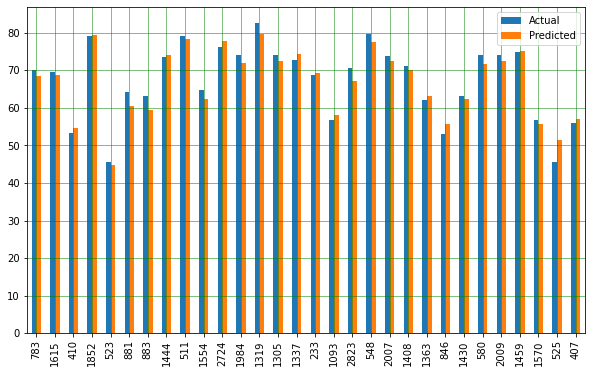

In [25]:
'''
Alternate prediction comparison visualisation
'''

# visualise actual vs predicted
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

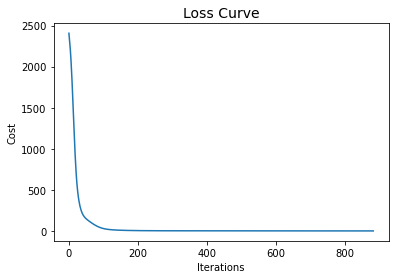

In [26]:
'''
Alternate prediction comparison visualisation
'''

# plot the loss curve of the ML algorithm
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

# Predicting Life Expectancy 
### Given values for Alcohol, BMI and Adult Mortality, we can observe the ANN's ability to predict Life Expectancy

In [27]:
'''
Print an entry to use values for prediction
'''

index = 1078
#index = 2907
print(reg_life_df.loc[[index]])

      STATUS  LIFE_EXPECTANCY  ALCOHOL  ADULT_MORTALITY  MEASLES  POLIO  \
1078       0             57.3     0.18              297      264   60.0   

      DIPHTHERIA   BMI  INFANT_DEATHS  THINNESS_5-9_YEARS  \
1078        57.0  23.0             29                 8.4   

      THINNESS_10-19_YEARS  SCHOOLING  INCOME_COMPOSITION_OF_RESOURCES  
1078                   8.4        8.1                            0.376  


In [28]:
'''
initialize prediction data
'''

# here we're getting a life expectancy prediction for the given values ## Life Exp
test1 = [[0, 0.18, 297, 23.1, 29, 264, 60.0, 57.0, 8.4, 8.4, 8.1, 0.376]] # 57.3
test2 = [[0, 4.36, 723, 27.1, 27, 31, 67.0, 65.0,  9.4, 9.4, 9.2, 0.407]]  # 44.3

# actual prediction
test3 = [[0, 5, 300, 19, 82, 1495, 68, 40, 18, 17, 14, 0.5]]  # ?

In [29]:
'''
Organise features to include 'LIFE_EXPECTANCY'
'''

x = reg_life_df[["STATUS", "ALCOHOL", "ADULT_MORTALITY", "BMI", "INFANT_DEATHS", "MEASLES", "POLIO", "DIPHTHERIA", "THINNESS_5-9_YEARS","THINNESS_10-19_YEARS", "SCHOOLING", "INCOME_COMPOSITION_OF_RESOURCES", "LIFE_EXPECTANCY"]]

In [31]:
'''
Peform prediction
'''

# convert to numpy array
x_array = x.to_numpy()

# initialsie the Multi-Layer-Perceptron Regressor with 3 lots of hidden layers
mlp2 = MLPRegressor(hidden_layer_sizes=(250, 150, 150),
                    # set max iterations
                    max_iter = 10000, 
                    # set the learning rate
                    learning_rate_init=0.0001,
                    # set the random state
                    random_state=12,
                    # choose the activation model
                    activation = 'relu',
                    # choose the solver
                    solver = 'adam'
                    #fit the data to train
                    ).fit(x_array[:,:-1], x_array[:,-1])

# predict a result from the given values using the training data
predict_result = mlp2.predict(test2)

# print prediction
print("Predicted Life Expectancy: ", predict_result[0])
print("Actual Life Expectancy: ", reg_life_df["LIFE_EXPECTANCY"].loc[index])

Predicted Life Expectancy:  55.01509232379059
Actual Life Expectancy:  57.3
